# Assignment 3 - Semantic Segmentation
### Syed Saad Ullah Shah
### 400202
### MSDS - CV
<hr >

## 1): Importing Packages

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm
!pip install -q torchsummary

from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2): Dataset Preprocessing

### Cityspace Dataset

The dataset is a subset of Cityspace Dataset and is already divided into train and test splits.
For validation, you can further split the Train part such that 80% is used for training and 20%
for validation.
Following classes are there in the dataset.
"Sky", "Building", "Pole","Road","Pavement","Tree","SignSymbol", "Fence", "Car",
"Pedestrian", "Bicyclist"

In [ ]:
# Downloading dataset
!gdown https://drive.google.com/file/d/1-9KNRTrsjQetmwT4Kamx391YEwkC43ue/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1-9KNRTrsjQetmwT4Kamx391YEwkC43ue
To: /content/A3_Dataset.zip
100% 126M/126M [00:00<00:00, 141MB/s]


In [ ]:
# Unzipping downloaded dataset
!unzip /content/A3_Dataset.zip

Archive:  /content/A3_Dataset.zip
replace A3_Dataset/dataset1/annotations_prepped_test/0016E5_07959.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Defining paths to dataset
MASK_PATH = "/content/A3_Dataset/dataset1/annotations_prepped_train/"
IMAGE_PATH = "/content/A3_Dataset/dataset1/images_prepped_train/"
MASK_PATH_TEST = "/content/A3_Dataset/dataset1/annotations_prepped_test/"
IMAGE_PATH_TEST = "/content/A3_Dataset/dataset1/images_prepped_test/"

In [ ]:
# Counting total Training images
n_classes = 12
name = []
def create_df():
    #name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  367


In [ ]:
# Counting total Testing images
n_classes = 12
name = []
def create_df():
    #name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH_TEST):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df_test = create_df()
print('Total Images: ', len(df_test))

Total Images:  101


In [ ]:
# Splitting dataset into Training, Validation and Testing setsS
X_test = df_test['id'].values
X_train, X_val = train_test_split(df['id'].values, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  311
Val Size     :  56
Test Size    :  101


In [ ]:
# Defining class for given dataset
from torchvision import transforms as T

class CityDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
            
        return img, mask

# Evaluation

### **Loading Model1: VGG13**

In [ ]:
best_val_model_path = './Pre-Trained_Models/vgg13_best_val_tensorboard.pth'
best_val_checkpoint = torch.load(best_val_model_path, map_location=torch.device(device))
# Before loading the state_dict of the model, make sure the "model" instance is 
# initiated by its corresponding class e.g. VGG13
model1.load_state_dict(best_val_checkpoint['model'])

TypeError: ignored

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_test = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)])
test_set = CityDataset(IMAGE_PATH_TEST, MASK_PATH_TEST, X_test, mean, std, t_test)

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    # t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    # image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [ ]:
def test_miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [ ]:
mob_miou = test_miou_score(model1, test_set)
np.mean(mob_miou)

In [ ]:
def display_for_comparison(image, mask, pred_mask):
  image = image.numpy().transpose(1,2,0)

  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
  ax1.imshow(image)
  ax1.set_title('Picture');

  ax2.imshow(mask)
  ax2.set_title('Ground truth')
  ax2.set_axis_off()

  ax3.imshow(pred_mask)
  ax3.set_title('UNet-VGG11 | mIoU {:.3f}'.format(score))
  ax3.set_axis_off()

In [ ]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model1, image, mask)

display_for_comparison(image, mask, pred_mask)

In [ ]:
image2, mask2 = test_set[9]
pred_mask2, score2 = predict_image_mask_miou(model1, image2, mask2)


display_for_comparison(image2, mask2, pred_mask2)

In [ ]:
image3, mask3 = test_set[15]
pred_mask3, score3 = predict_image_mask_miou(model1, image3, mask3)


display_for_comparison(image3, mask3, pred_mask3)

### **Loading Model2: VGG19**

In [ ]:
best_val_model_path = './Pre-Trained_Models/vgg19_best_val_tensorboard.pth'
best_val_checkpoint = torch.load(best_val_model_path, map_location=torch.device(device))
# Before loading the state_dict of the model, make sure the "model" instance is 
# initiated by its corresponding class e.g. VGG19
model2.load_state_dict(best_val_checkpoint['model'])

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_test = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)])
test_set = CityDataset(IMAGE_PATH_TEST, MASK_PATH_TEST, X_test, mean, std, t_test)

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    # t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    # image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [ ]:
def test_miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [ ]:
mob_miou = test_miou_score(model2, test_set)
np.mean(mob_miou)

In [ ]:
def display_for_comparison(image, mask, pred_mask):
  image = image.numpy().transpose(1,2,0)

  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
  ax1.imshow(image)
  ax1.set_title('Picture');

  ax2.imshow(mask)
  ax2.set_title('Ground truth')
  ax2.set_axis_off()

  ax3.imshow(pred_mask)
  ax3.set_title('UNet-VGG11 | mIoU {:.3f}'.format(score))
  ax3.set_axis_off()

In [ ]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model2, image, mask)

display_for_comparison(image, mask, pred_mask)

In [ ]:
image2, mask2 = test_set[9]
pred_mask2, score2 = predict_image_mask_miou(model2, image2, mask2)


display_for_comparison(image2, mask2, pred_mask2)

In [ ]:
image3, mask3 = test_set[15]
pred_mask3, score3 = predict_image_mask_miou(model2, image3, mask3)


display_for_comparison(image3, mask3, pred_mask3)

### **Loading Model3: MobileNet**

In [ ]:
best_val_model_path = './Pre-Trained_Models/mobilenet_best_val_tensorboard.pth'
best_val_checkpoint = torch.load(best_val_model_path, map_location=torch.device(device))
# Before loading the state_dict of the model, make sure the "model" instance is 
# initiated by its corresponding class e.g. MobileNet
model3.load_state_dict(best_val_checkpoint['model'])

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_test = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)])
test_set = CityDataset(IMAGE_PATH_TEST, MASK_PATH_TEST, X_test, mean, std, t_test)

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    # t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    # image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [ ]:
def test_miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [ ]:
mob_miou = test_miou_score(model3, test_set)
np.mean(mob_miou)

In [ ]:
def display_for_comparison(image, mask, pred_mask):
  image = image.numpy().transpose(1,2,0)

  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
  ax1.imshow(image)
  ax1.set_title('Picture');

  ax2.imshow(mask)
  ax2.set_title('Ground truth')
  ax2.set_axis_off()

  ax3.imshow(pred_mask)
  ax3.set_title('UNet-VGG11 | mIoU {:.3f}'.format(score))
  ax3.set_axis_off()

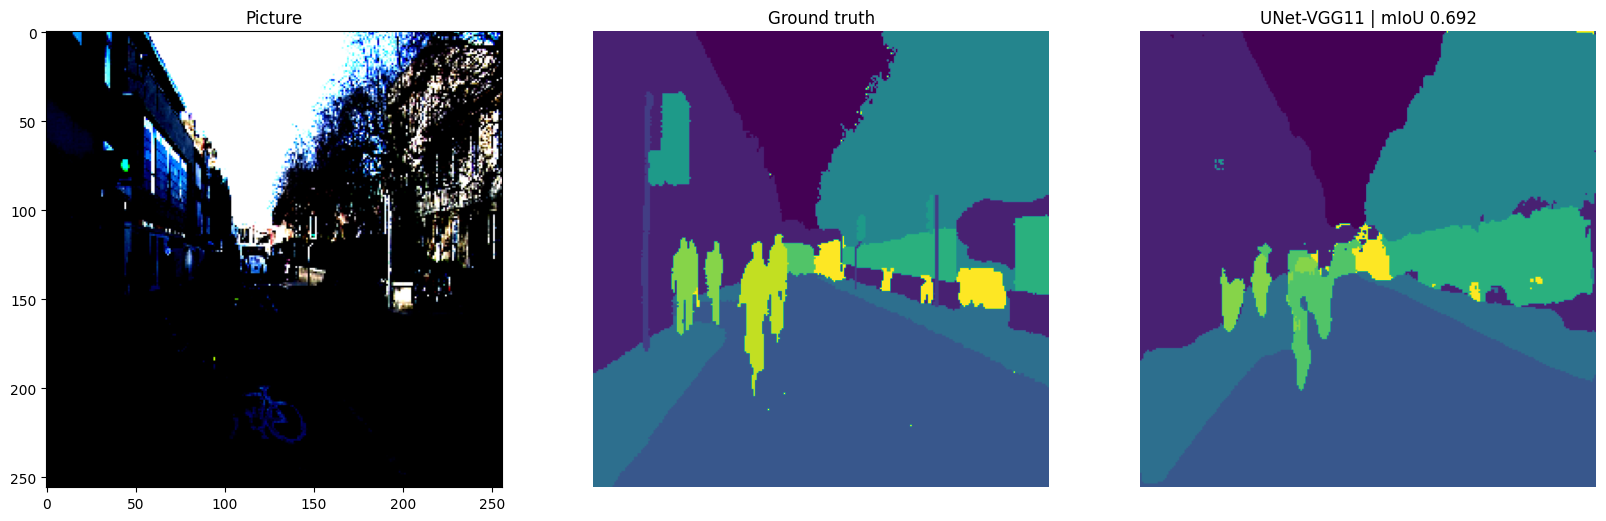

In [ ]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model3, image, mask)

display_for_comparison(image, mask, pred_mask)

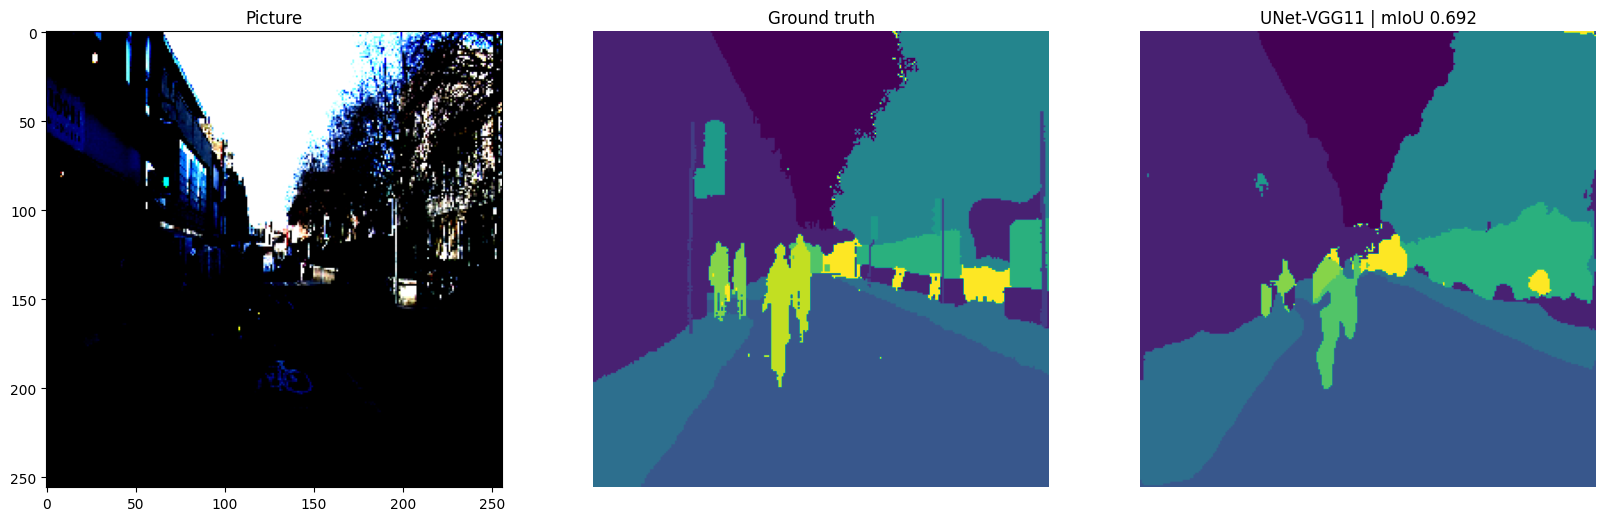

In [ ]:
image2, mask2 = test_set[9]
pred_mask2, score2 = predict_image_mask_miou(model3, image2, mask2)


display_for_comparison(image2, mask2, pred_mask2)

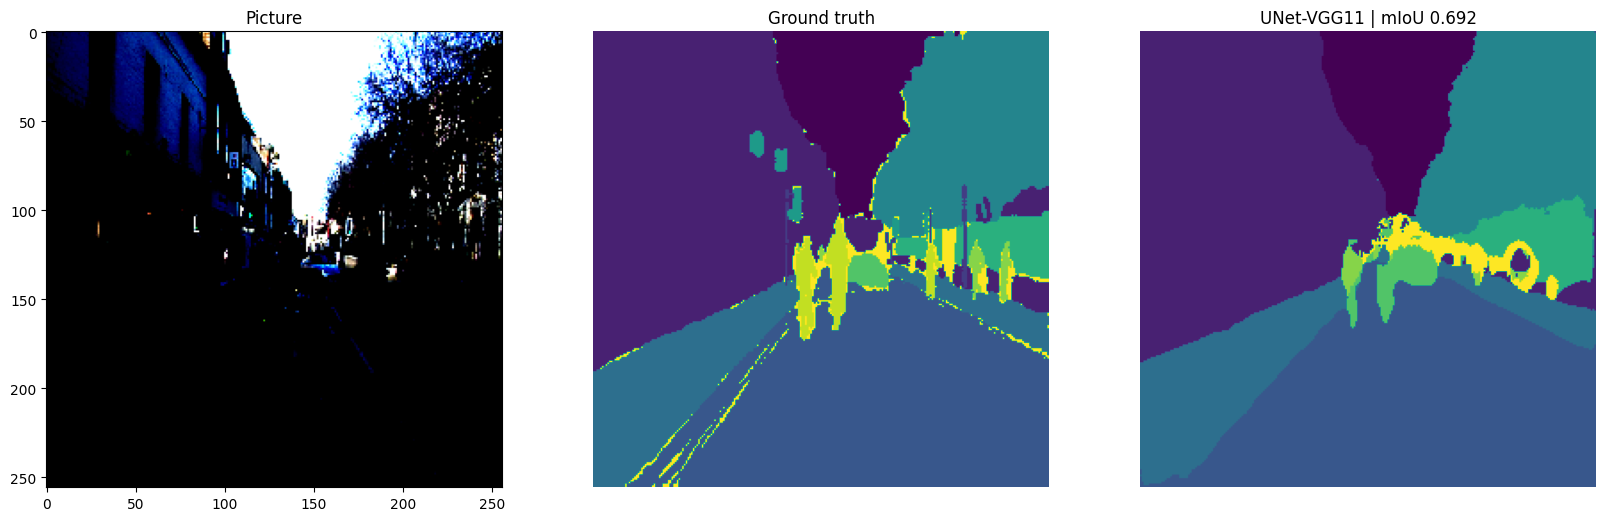

In [ ]:
image3, mask3 = test_set[15]
pred_mask3, score3 = predict_image_mask_miou(model3, image3, mask3)


display_for_comparison(image3, mask3, pred_mask3)